## CELL 1: Environment Setup & Imports


In [1]:
# ============================================================
# CELL 1: ENVIRONMENT SETUP & IMPORTS
# ============================================================

import os
import sys
import json
import pickle
import random
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

# Vision
import torchvision
from torchvision import transforms
from PIL import Image

# Data
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Timm for ViT
try:
    import timm
except ImportError:
    print("Installing timm library...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "timm"])
    import timm

# ============================================================
# SETUP
# ============================================================

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print("="*80)
print("NOTEBOOK 9A: ABLATION STUDY - SINGLE GPU")
print("="*80)
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Timm Version: {timm.__version__}")
print("="*80)

# ============================================================
# PATH SETUP
# ============================================================

BASE_DIR = Path('./novelty_files')
CHECKPOINTS_DIR = BASE_DIR / 'checkpoints' / 'ablation'
LOGS_DIR = BASE_DIR / 'logs' / 'ablation'
METRICS_DIR = BASE_DIR / 'metrics'
DATA_DIR = Path('./fight_dataset/actions (2)/actions')

CHECKPOINTS_DIR.mkdir(parents=True, exist_ok=True)
LOGS_DIR.mkdir(parents=True, exist_ok=True)
METRICS_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Checkpoint directory: {CHECKPOINTS_DIR}")
print(f"✓ Logs directory: {LOGS_DIR}")
print(f"✓ Metrics directory: {METRICS_DIR}")
print(f"✓ Data directory: {DATA_DIR}")
print("="*80)

NOTEBOOK 9A: ABLATION STUDY - SINGLE GPU
PyTorch Version: 2.9.1+cu128
CUDA Available: True
Device: cuda:0
GPU: NVIDIA H200
Timm Version: 1.0.22

✓ Checkpoint directory: novelty_files/checkpoints/ablation
✓ Logs directory: novelty_files/logs/ablation
✓ Metrics directory: novelty_files/metrics
✓ Data directory: fight_dataset/actions (2)/actions


## CELL 2: Load Configuration & Splits


In [2]:
# ============================================================
# CELL 2: LOAD CONFIGURATION & SPLITS
# ============================================================

print("\n" + "="*80)
print("LOADING CONFIGURATION & DATA")
print("="*80)

# Load configuration
config_path = BASE_DIR / 'configs' / 'notebook_01_config.json'
with open(config_path, 'r') as f:
    CONFIG = json.load(f)
print(f"✓ Loaded configuration from {config_path}")

# Load class distribution
dist_path = BASE_DIR / 'splits' / 'class_distribution.json'
with open(dist_path, 'r') as f:
    dist_data = json.load(f)

class_to_idx = dist_data['class_to_idx']
idx_to_class = {int(k): v for k, v in dist_data['idx_to_class'].items()}
print(f"✓ Loaded class mappings ({len(class_to_idx)} classes)")

# Load train/val/test splits
with open(BASE_DIR / 'splits' / 'train_indices.pkl', 'rb') as f:
    train_indices = pickle.load(f)
with open(BASE_DIR / 'splits' / 'val_indices.pkl', 'rb') as f:
    val_indices = pickle.load(f)
with open(BASE_DIR / 'splits' / 'test_indices.pkl', 'rb') as f:
    test_indices = pickle.load(f)

print(f"✓ Loaded splits:")
print(f"  Train: {len(train_indices):,} samples")
print(f"  Val:   {len(val_indices):,} samples")
print(f"  Test:  {len(test_indices):,} samples")

# Load neighbor indices for NSL (if exists)
neighbor_path = BASE_DIR / 'graphs' / 'train_neighbors.npy'
if neighbor_path.exists():
    neighbor_indices = np.load(neighbor_path)
    print(f"✓ Loaded neighbor indices: {neighbor_indices.shape}")
else:
    neighbor_indices = None
    print("⚠ No neighbor indices found (required for NSL configs)")
    print("  Run Notebook 3 first to generate graph data")

# Rebuild dataset samples
class HMDB51FightDataset(Dataset):
    def __init__(self, root_dir: str, split: str, class_to_idx: Dict[str, int]):
        self.root_dir = Path(root_dir)
        self.split = split
        self.class_to_idx = class_to_idx
        self.samples = []
        
        split_dir = self.root_dir / split
        for class_name, class_idx in class_to_idx.items():
            class_dir = split_dir / class_name
            if class_dir.exists():
                image_files = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png'))
                for img_path in image_files:
                    self.samples.append({
                        'path': str(img_path),
                        'label': class_idx,
                        'class_name': class_name
                    })
    
    def __len__(self):
        return len(self.samples)

dataset_path = CONFIG['dataset_path']
train_dataset_loader = HMDB51FightDataset(dataset_path, 'train', class_to_idx)
test_dataset_loader = HMDB51FightDataset(dataset_path, 'test', class_to_idx)
all_samples = train_dataset_loader.samples + test_dataset_loader.samples

print(f"✓ Reloaded {len(all_samples):,} samples")
print("="*80)


LOADING CONFIGURATION & DATA
✓ Loaded configuration from novelty_files/configs/notebook_01_config.json
✓ Loaded class mappings (8 classes)
✓ Loaded splits:
  Train: 53,097 samples
  Val:   11,379 samples
  Test:  11,379 samples
✓ Loaded neighbor indices: (53097, 5)
✓ Reloaded 75,855 samples


## CELL 3: Dataset Class with NSL Support


In [3]:
# ============================================================
# CELL 3: DATASET CLASS
# ============================================================

class HMDB51Dataset(Dataset):
    """
    HMDB51 Dataset with optional neighbor support for NSL.
    
    Args:
        samples: List of sample dictionaries
        indices: List of indices to use
        transform: Torchvision transforms
        return_neighbors: If True, also return neighbor indices for NSL
        neighbor_indices: Precomputed k-NN indices
    """
    
    def __init__(self, samples: List[Dict], indices: List[int], 
                 transform=None, return_neighbors: bool = False, 
                 neighbor_indices: Optional[np.ndarray] = None):
        self.samples = [samples[i] for i in indices]
        self.transform = transform
        self.return_neighbors = return_neighbors
        self.neighbor_indices = neighbor_indices
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        img_path = sample['path']
        label = sample['label']
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        if self.return_neighbors and self.neighbor_indices is not None:
            neighbors = self.neighbor_indices[idx]
            return image, label, neighbors
        
        return image, label

print("✓ Dataset class defined with NSL support")

✓ Dataset class defined with NSL support


## CELL 4: Transform Functions


In [4]:
# ============================================================
# CELL 4: TRANSFORM FUNCTIONS
# ============================================================

def get_base_transform():
    """Base transform without augmentation."""
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def get_basic_aug_transform():
    """Basic augmentation: flip, rotation, color jitter."""
    return transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

print("✓ Transform functions defined")
print("  • get_base_transform() - Resize + Normalize")
print("  • get_basic_aug_transform() - Flip, Rotation, ColorJitter")

✓ Transform functions defined
  • get_base_transform() - Resize + Normalize
  • get_basic_aug_transform() - Flip, Rotation, ColorJitter


## CELL 5: Augmentation Functions (MixUp, CutMix)


In [5]:
# ============================================================
# CELL 5: AUGMENTATION FUNCTIONS (MIXUP, CUTMIX)
# ============================================================

def mixup_data(x: torch.Tensor, y: torch.Tensor, alpha: float = 0.4):
    """
    MixUp: Linear interpolation between random pairs of samples.
    
    Args:
        x: Input images [B, C, H, W]
        y: Labels [B]
        alpha: Beta distribution parameter
    
    Returns:
        mixed_x: Mixed images
        y_a, y_b: Original labels
        lam: Mixing coefficient
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    
    batch_size = x.size(0)
    index = torch.randperm(batch_size, device=x.device)
    
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    
    return mixed_x, y_a, y_b, lam

def rand_bbox(size, lam):
    """Generate random bounding box for CutMix."""
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    
    return bbx1, bby1, bbx2, bby2

def cutmix_data(x: torch.Tensor, y: torch.Tensor, alpha: float = 1.0):
    """
    CutMix: Cut and paste rectangular regions.
    
    Args:
        x: Input images [B, C, H, W]
        y: Labels [B]
        alpha: Beta distribution parameter
    
    Returns:
        mixed_x: CutMix images
        y_a, y_b: Original labels
        lam: Adjusted mixing coefficient (based on actual area)
    """
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size, device=x.device)
    
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    
    mixed_x = x.clone()
    mixed_x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]
    
    # Adjust lambda based on actual area
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size(-1) * x.size(-2)))
    
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Compute MixUp/CutMix loss."""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

print("✓ Augmentation functions defined")
print("  • mixup_data() - Linear interpolation")
print("  • cutmix_data() - Cut and paste")
print("  • mixup_criterion() - Mixed loss")

✓ Augmentation functions defined
  • mixup_data() - Linear interpolation
  • cutmix_data() - Cut and paste
  • mixup_criterion() - Mixed loss


## CELL 6: NSL Loss Functions


In [6]:
# ============================================================
# CELL 6: NSL LOSS FUNCTIONS
# ============================================================

def virtual_adversarial_loss(model, x: torch.Tensor, logits: torch.Tensor, 
                              xi: float = 1e-6, eps: float = 2.0, 
                              num_iters: int = 1):
    """
    Virtual Adversarial Training (VAT) loss.
    Encourages locally smooth predictions.
    """
    # Initialize random perturbation
    d = torch.randn_like(x, requires_grad=False)
    d = d / (torch.norm(d.view(d.size(0), -1), dim=1, keepdim=True).unsqueeze(-1).unsqueeze(-1) + 1e-8)
    
    for _ in range(num_iters):
        d = d.clone().detach().requires_grad_(True)
        pred_hat = model(x + xi * d)
        
        # KL divergence
        logp = F.log_softmax(pred_hat, dim=1)
        p = F.softmax(logits.detach(), dim=1)
        kl = F.kl_div(logp, p, reduction='batchmean')
        
        kl.backward()
        d = d.grad.data.clone()
        d = d / (torch.norm(d.view(d.size(0), -1), dim=1, keepdim=True).unsqueeze(-1).unsqueeze(-1) + 1e-8)
        model.zero_grad()
    
    # Final adversarial perturbation
    r_adv = eps * d.detach()
    pred_hat = model(x + r_adv)
    
    logp_hat = F.log_softmax(pred_hat, dim=1)
    p = F.softmax(logits.detach(), dim=1)
    vat_loss = F.kl_div(logp_hat, p, reduction='batchmean')
    
    return vat_loss

def l2_neighbor_loss(embeddings: torch.Tensor, neighbor_embeddings: torch.Tensor):
    """
    Neighbor regularization loss from NSL.
    Encourages similar embeddings for neighboring samples.
    """
    # Average neighbor embeddings
    avg_neighbor = neighbor_embeddings.mean(dim=1)  # [B, D]
    
    # L2 distance
    diff = embeddings - avg_neighbor
    loss = (diff ** 2).sum(dim=1).mean()
    
    return loss

print("✓ NSL loss functions defined")
print("  • virtual_adversarial_loss() - VAT regularization")
print("  • l2_neighbor_loss() - Neighbor consistency")

✓ NSL loss functions defined
  • virtual_adversarial_loss() - VAT regularization
  • l2_neighbor_loss() - Neighbor consistency


## CELL 7: PGD Adversarial Attack


In [7]:
# ============================================================
# CELL 7: PGD ADVERSARIAL ATTACK
# ============================================================

def pgd_attack(model, images: torch.Tensor, labels: torch.Tensor,
               eps: float = 8/255, alpha: float = 2/255, 
               num_steps: int = 7, random_start: bool = True):
    """
    Projected Gradient Descent (PGD) adversarial attack.
    
    Args:
        model: Target model
        images: Input images
        labels: True labels
        eps: Maximum perturbation (L-inf norm)
        alpha: Step size
        num_steps: Number of attack iterations
        random_start: Whether to initialize with random noise
    
    Returns:
        adv_images: Adversarial examples
    """
    images = images.clone().detach()
    adv_images = images.clone().detach()
    
    if random_start:
        # Start from random point within epsilon ball
        adv_images = adv_images + torch.empty_like(adv_images).uniform_(-eps, eps)
        adv_images = torch.clamp(adv_images, 0, 1)
    
    for _ in range(num_steps):
        adv_images.requires_grad = True
        outputs = model(adv_images)
        loss = F.cross_entropy(outputs, labels)
        
        grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
        
        # FGSM step
        adv_images = adv_images.detach() + alpha * grad.sign()
        
        # Project back to epsilon ball
        delta = torch.clamp(adv_images - images, -eps, eps)
        adv_images = torch.clamp(images + delta, 0, 1)
    
    return adv_images.detach()

print("✓ PGD adversarial attack function defined")
print("  • pgd_attack() - 7-step PGD with ε=8/255")

✓ PGD adversarial attack function defined
  • pgd_attack() - 7-step PGD with ε=8/255


## CELL 8: CBAM Attention Modules


In [8]:
# ============================================================
# CELL 8: CBAM ATTENTION MODULES
# ============================================================

class ChannelAttention(nn.Module):
    """Channel attention module from CBAM."""
    
    def __init__(self, in_channels: int, reduction: int = 16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        b, c, _, _ = x.size()
        
        avg_out = self.mlp(self.avg_pool(x).view(b, c))
        max_out = self.mlp(self.max_pool(x).view(b, c))
        
        attention = self.sigmoid(avg_out + max_out).view(b, c, 1, 1)
        return x * attention

class SpatialAttention(nn.Module):
    """Spatial attention module from CBAM."""
    
    def __init__(self, kernel_size: int = 7):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        avg_out = x.mean(dim=1, keepdim=True)
        max_out = x.max(dim=1, keepdim=True)[0]
        combined = torch.cat([avg_out, max_out], dim=1)
        
        attention = self.sigmoid(self.conv(combined))
        return x * attention

class CBAM(nn.Module):
    """Convolutional Block Attention Module."""
    
    def __init__(self, in_channels: int, reduction: int = 16, kernel_size: int = 7):
        super().__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention(kernel_size)
    
    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

print("✓ CBAM attention modules defined")
print("  • ChannelAttention - Channel-wise attention")
print("  • SpatialAttention - Spatial attention")
print("  • CBAM - Combined module")

✓ CBAM attention modules defined
  • ChannelAttention - Channel-wise attention
  • SpatialAttention - Spatial attention
  • CBAM - Combined module


## CELL 9: Model Architectures


In [9]:
# ============================================================
# CELL 9: MODEL ARCHITECTURES
# ============================================================

def create_vit_model(num_classes: int = 8, pretrained: bool = True):
    """Create ViT-Base/16 model."""
    model = timm.create_model('vit_base_patch16_224', pretrained=pretrained)
    model.head = nn.Linear(model.head.in_features, num_classes)
    return model

def create_vgg16_model(num_classes: int = 8, pretrained: bool = True):
    """Create VGG-16 model for baseline."""
    model = torchvision.models.vgg16(pretrained=pretrained)
    model.classifier[-1] = nn.Linear(4096, num_classes)
    return model

class ViTWithCBAM(nn.Module):
    """ViT with CBAM attention module."""
    
    def __init__(self, num_classes: int = 8, pretrained: bool = True):
        super().__init__()
        
        # Load pretrained ViT
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=pretrained)
        hidden_dim = self.vit.head.in_features  # 768
        
        # Remove original head
        self.vit.head = nn.Identity()
        
        # CBAM on reshaped features
        self.cbam = CBAM(hidden_dim, reduction=16)
        
        # New classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        # Get ViT features
        features = self.vit.forward_features(x)  # [B, 197, 768]
        cls_token = features[:, 0]  # [B, 768]
        
        # Apply CBAM (reshape for 2D attention)
        cls_reshaped = cls_token.unsqueeze(-1).unsqueeze(-1)  # [B, 768, 1, 1]
        attended = self.cbam(cls_reshaped)  # [B, 768, 1, 1]
        attended = attended.squeeze(-1).squeeze(-1)  # [B, 768]
        
        # Classify
        out = self.classifier(attended)
        return out
    
    def get_embeddings(self, x):
        """Get feature embeddings before classifier."""
        features = self.vit.forward_features(x)
        cls_token = features[:, 0]
        cls_reshaped = cls_token.unsqueeze(-1).unsqueeze(-1)
        attended = self.cbam(cls_reshaped)
        return attended.squeeze(-1).squeeze(-1)

print("✓ Model architectures defined")
print("  • create_vit_model() - ViT-Base/16")
print("  • create_vgg16_model() - VGG-16")
print("  • ViTWithCBAM - ViT + CBAM attention")

✓ Model architectures defined
  • create_vit_model() - ViT-Base/16
  • create_vgg16_model() - VGG-16
  • ViTWithCBAM - ViT + CBAM attention


## CELL 10: Training & Validation Functions


In [10]:
# ============================================================
# CELL 10: TRAINING & VALIDATION FUNCTIONS
# ============================================================

def train_one_epoch(model, train_loader, criterion, optimizer, device, config):
    """
    Train model for one epoch with configurable augmentation.
    
    Args:
        model: Neural network
        train_loader: Training DataLoader
        criterion: Loss function
        optimizer: Optimizer
        device: Device to train on
        config: Configuration dict with flags for components
    
    Returns:
        avg_loss: Average training loss
        accuracy: Training accuracy
    """
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    use_mixup = config.get('use_mixup', False)
    use_cutmix = config.get('use_cutmix', False)
    use_nsl = config.get('use_nsl', False)
    use_pgd = config.get('use_pgd', False)
    
    for batch_idx, batch_data in enumerate(train_loader):
        if len(batch_data) == 3:  # With neighbors
            images, labels, neighbors = batch_data
            images = images.to(device)
            labels = labels.to(device)
        else:
            images, labels = batch_data
            images = images.to(device)
            labels = labels.to(device)
        
        # PGD adversarial training
        if use_pgd:
            model.eval()
            adv_images = pgd_attack(model, images, labels)
            model.train()
            
            # Train on mix of clean and adversarial
            clean_outputs = model(images)
            adv_outputs = model(adv_images)
            
            clean_loss = criterion(clean_outputs, labels)
            adv_loss = criterion(adv_outputs, labels)
            loss = 0.5 * clean_loss + 0.5 * adv_loss
            
            outputs = clean_outputs  # For accuracy calculation
        else:
            # Apply MixUp or CutMix
            if use_mixup and np.random.random() < 0.5:
                images, labels_a, labels_b, lam = mixup_data(images, labels)
                outputs = model(images)
                loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
            elif use_cutmix and np.random.random() < 0.5:
                images, labels_a, labels_b, lam = cutmix_data(images, labels)
                outputs = model(images)
                loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            # Add NSL loss if enabled
            if use_nsl:
                vat_loss = virtual_adversarial_loss(model, images, outputs)
                loss = loss + 1.0 * vat_loss
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100.0 * correct / total
    
    return avg_loss, accuracy

def validate(model, val_loader, device):
    """
    Validate model on validation set.
    
    Returns:
        accuracy: Validation accuracy
    """
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_data in val_loader:
            if len(batch_data) == 3:  # With neighbors
                images, labels, _ = batch_data
            else:
                images, labels = batch_data
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    accuracy = 100.0 * correct / total
    return accuracy

print("✓ Training functions defined")
print("  • train_one_epoch() - Configurable training loop")
print("  • validate() - Validation accuracy")

✓ Training functions defined
  • train_one_epoch() - Configurable training loop
  • validate() - Validation accuracy


## CELL 11: Generic Ablation Runner


In [11]:
# ============================================================
# CELL 11: GENERIC ABLATION RUNNER (RESTART-SAFE)
# ============================================================

def run_ablation(config_name, config_dict, train_indices, val_indices, 
                 class_to_idx, all_samples, neighbor_indices=None, device='cuda:0'):
    """
    Generic ablation runner - handles checkpoint loading, training, saving.
    
    RESTART-SAFE: Checks for existing checkpoint first.
    
    Args:
        config_name: Name of configuration (e.g., '01_VGG16_Baseline')
        config_dict: Configuration dictionary
        train_indices: Training indices
        val_indices: Validation indices
        class_to_idx: Class mapping
        all_samples: All dataset samples
        neighbor_indices: k-NN indices for NSL (optional)
        device: Device to train on
    
    Returns:
        val_accuracy: Best validation accuracy
    """
    print("\n" + "="*80)
    print(f"RUNNING ABLATION: {config_name}")
    print("="*80)
    
    checkpoint_path = CHECKPOINTS_DIR / f"{config_name}.pt"
    
    # RESTART-SAFE: Check if checkpoint exists
    if checkpoint_path.exists():
        print(f"✓ Found existing checkpoint: {checkpoint_path}")
        ckpt = torch.load(checkpoint_path, map_location=device)
        val_acc = ckpt['val_accuracy']
        print(f"  Val Accuracy: {val_acc:.2f}%")
        print("  Skipping training (restart-safe)")
        return val_acc
    
    print(f"No existing checkpoint found. Training {config_name}...")
    print(f"Configuration:")
    for key, value in config_dict.items():
        print(f"  {key}: {value}")
    
    # Extract config
    model_type = config_dict['model_type']
    epochs = config_dict['epochs']
    batch_size = config_dict['batch_size']
    learning_rate = config_dict['learning_rate']
    use_basicaug = config_dict['use_basicaug']
    use_nsl = config_dict.get('use_nsl', False)
    
    # Create transforms
    train_transform = get_basic_aug_transform() if use_basicaug else get_base_transform()
    val_transform = get_base_transform()
    
    # Create datasets
    train_dataset = HMDB51Dataset(
        all_samples, train_indices, transform=train_transform,
        return_neighbors=use_nsl, neighbor_indices=neighbor_indices
    )
    val_dataset = HMDB51Dataset(
        all_samples, val_indices, transform=val_transform,
        return_neighbors=False
    )
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=4, pin_memory=True, drop_last=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=4, pin_memory=True
    )
    
    print(f"\nDatasets created:")
    print(f"  Train: {len(train_dataset)} samples, {len(train_loader)} batches")
    print(f"  Val:   {len(val_dataset)} samples, {len(val_loader)} batches")
    
    # Create model
    use_cbam = config_dict.get('use_cbam', False)
    if model_type == 'vgg16':
        model = create_vgg16_model(num_classes=8)
        print("✓ Created VGG-16 model")
    elif use_cbam:
        model = ViTWithCBAM(num_classes=8)
        print("✓ Created ViT + CBAM model")
    else:
        model = create_vit_model(num_classes=8)
        print("✓ Created ViT-Base model")
    
    model = model.to(device)
    
    # Optimizer and scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
    
    # Training loop
    best_val_acc = 0.0
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 60)
        
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device, config_dict
        )
        
        val_acc = validate(model, val_loader, device)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Acc: {val_acc:.2f}%")
        
        scheduler.step()
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_accuracy': val_acc,
                'config': config_dict,
            }
            torch.save(checkpoint, checkpoint_path)
            print(f"✓ Best model saved (val_acc={val_acc:.2f}%)")
    
    print(f"\n" + "="*80)
    print(f"{config_name} COMPLETE")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"Checkpoint: {checkpoint_path}")
    print("="*80)
    
    return best_val_acc

print("✓ Generic ablation runner defined")
print("  • Restart-safe: checks for existing checkpoints")
print("  • Configurable: supports all component combinations")

✓ Generic ablation runner defined
  • Restart-safe: checks for existing checkpoints
  • Configurable: supports all component combinations


## CELL 12: Config 01 - VGG-16 Baseline


In [12]:
# ============================================================
# CONFIG 01: VGG-16 BASELINE
# ============================================================

config_01 = {
    'name': '01_VGG16_Baseline',
    'model_type': 'vgg16',
    'epochs': 1,
    'batch_size': 32,
    'learning_rate': 1e-4,
    'use_basicaug': False,
    'use_mixup': False,
    'use_cutmix': False,
    'use_nsl': False,
    'use_cbam': False,
    'use_pgd': False
}

acc_01 = run_ablation(
    config_01['name'], 
    config_01, 
    train_indices, 
    val_indices,
    class_to_idx,
    all_samples,
    neighbor_indices=None,
    device=device
)

print(f"\n{'='*80}")
print(f"01_VGG16_Baseline: {acc_01:.2f}%")
print(f"Expected: ~71% (baseline from base paper)")
print(f"{'='*80}")


RUNNING ABLATION: 01_VGG16_Baseline
✓ Found existing checkpoint: novelty_files/checkpoints/ablation/01_VGG16_Baseline.pt
  Val Accuracy: 99.53%
  Skipping training (restart-safe)

01_VGG16_Baseline: 99.53%
Expected: ~71% (baseline from base paper)


## CELL 13: Config 03 - ViT + Basic Augmentation


In [13]:
# ============================================================
# CONFIG 03: VIT + BASIC AUGMENTATION
# ============================================================

config_03 = {
    'name': '03_ViT_BasicAug',
    'model_type': 'vit',
    'epochs': 1,
    'batch_size': 64,
    'learning_rate': 1e-4,
    'use_basicaug': True,
    'use_mixup': False,
    'use_cutmix': False,
    'use_nsl': False,
    'use_cbam': False,
    'use_pgd': False
}

acc_03 = run_ablation(
    config_03['name'], 
    config_03, 
    train_indices, 
    val_indices,
    class_to_idx,
    all_samples,
    neighbor_indices=None,
    device=device
)

print(f"\n{'='*80}")
print(f"03_ViT_BasicAug: {acc_03:.2f}%")
print(f"Expected: ~78-80% (ViT with basic augmentation)")
print(f"{'='*80}")


RUNNING ABLATION: 03_ViT_BasicAug
No existing checkpoint found. Training 03_ViT_BasicAug...
Configuration:
  name: 03_ViT_BasicAug
  model_type: vit
  epochs: 1
  batch_size: 64
  learning_rate: 0.0001
  use_basicaug: True
  use_mixup: False
  use_cutmix: False
  use_nsl: False
  use_cbam: False
  use_pgd: False

Datasets created:
  Train: 53097 samples, 829 batches
  Val:   11379 samples, 178 batches
✓ Created ViT-Base model

Epoch 1/1
------------------------------------------------------------
Train Loss: 0.1812, Train Acc: 94.12%
Val Acc: 98.01%
✓ Best model saved (val_acc=98.01%)

03_ViT_BasicAug COMPLETE
Best Validation Accuracy: 98.01%
Checkpoint: novelty_files/checkpoints/ablation/03_ViT_BasicAug.pt

03_ViT_BasicAug: 98.01%
Expected: ~78-80% (ViT with basic augmentation)


## CELL 14: Config 04 - ViT + MixUp Only


In [14]:
# ============================================================
# CONFIG 04: VIT + MIXUP ONLY
# ============================================================

config_04 = {
    'name': '04_ViT_MixUp',
    'model_type': 'vit',
    'epochs': 1,
    'batch_size': 64,
    'learning_rate': 1e-4,
    'use_basicaug': False,
    'use_mixup': True,
    'use_cutmix': False,
    'use_nsl': False,
    'use_cbam': False,
    'use_pgd': False
}

acc_04 = run_ablation(
    config_04['name'], 
    config_04, 
    train_indices, 
    val_indices,
    class_to_idx,
    all_samples,
    neighbor_indices=None,
    device=device
)

print(f"\n{'='*80}")
print(f"04_ViT_MixUp: {acc_04:.2f}%")
print(f"Expected: ~79-81% (MixUp augmentation)")
print(f"{'='*80}")


RUNNING ABLATION: 04_ViT_MixUp
No existing checkpoint found. Training 04_ViT_MixUp...
Configuration:
  name: 04_ViT_MixUp
  model_type: vit
  epochs: 1
  batch_size: 64
  learning_rate: 0.0001
  use_basicaug: False
  use_mixup: True
  use_cutmix: False
  use_nsl: False
  use_cbam: False
  use_pgd: False

Datasets created:
  Train: 53097 samples, 829 batches
  Val:   11379 samples, 178 batches
✓ Created ViT-Base model

Epoch 1/1
------------------------------------------------------------
Train Loss: 0.4178, Train Acc: 77.21%
Val Acc: 98.51%
✓ Best model saved (val_acc=98.51%)

04_ViT_MixUp COMPLETE
Best Validation Accuracy: 98.51%
Checkpoint: novelty_files/checkpoints/ablation/04_ViT_MixUp.pt

04_ViT_MixUp: 98.51%
Expected: ~79-81% (MixUp augmentation)


## CELL 15: Config 05 - ViT + CutMix Only


In [15]:
# ============================================================
# CONFIG 05: VIT + CUTMIX ONLY
# ============================================================

config_05 = {
    'name': '05_ViT_CutMix',
    'model_type': 'vit',
    'epochs': 1,
    'batch_size': 64,
    'learning_rate': 1e-4,
    'use_basicaug': False,
    'use_mixup': False,
    'use_cutmix': True,
    'use_nsl': False,
    'use_cbam': False,
    'use_pgd': False
}

acc_05 = run_ablation(
    config_05['name'], 
    config_05, 
    train_indices, 
    val_indices,
    class_to_idx,
    all_samples,
    neighbor_indices=None,
    device=device
)

print(f"\n{'='*80}")
print(f"05_ViT_CutMix: {acc_05:.2f}%")
print(f"Expected: ~79-81% (CutMix augmentation)")
print(f"{'='*80}")


RUNNING ABLATION: 05_ViT_CutMix
No existing checkpoint found. Training 05_ViT_CutMix...
Configuration:
  name: 05_ViT_CutMix
  model_type: vit
  epochs: 1
  batch_size: 64
  learning_rate: 0.0001
  use_basicaug: False
  use_mixup: False
  use_cutmix: True
  use_nsl: False
  use_cbam: False
  use_pgd: False

Datasets created:
  Train: 53097 samples, 829 batches
  Val:   11379 samples, 178 batches
✓ Created ViT-Base model

Epoch 1/1
------------------------------------------------------------
Train Loss: 0.4985, Train Acc: 84.87%
Val Acc: 99.20%
✓ Best model saved (val_acc=99.20%)

05_ViT_CutMix COMPLETE
Best Validation Accuracy: 99.20%
Checkpoint: novelty_files/checkpoints/ablation/05_ViT_CutMix.pt

05_ViT_CutMix: 99.20%
Expected: ~79-81% (CutMix augmentation)


## CELL 16: Config 06 - ViT + MixUp + CutMix


In [16]:
# ============================================================
# CONFIG 06: VIT + MIXUP + CUTMIX
# ============================================================

config_06 = {
    'name': '06_ViT_MixUp_CutMix',
    'model_type': 'vit',
    'epochs': 1,
    'batch_size': 64,
    'learning_rate': 1e-4,
    'use_basicaug': False,
    'use_mixup': True,
    'use_cutmix': True,
    'use_nsl': False,
    'use_cbam': False,
    'use_pgd': False
}

acc_06 = run_ablation(
    config_06['name'], 
    config_06, 
    train_indices, 
    val_indices,
    class_to_idx,
    all_samples,
    neighbor_indices=None,
    device=device
)

print(f"\n{'='*80}")
print(f"06_ViT_MixUp_CutMix: {acc_06:.2f}%")
print(f"Expected: ~80-82% (combined augmentation)")
print(f"{'='*80}")


RUNNING ABLATION: 06_ViT_MixUp_CutMix
No existing checkpoint found. Training 06_ViT_MixUp_CutMix...
Configuration:
  name: 06_ViT_MixUp_CutMix
  model_type: vit
  epochs: 1
  batch_size: 64
  learning_rate: 0.0001
  use_basicaug: False
  use_mixup: True
  use_cutmix: True
  use_nsl: False
  use_cbam: False
  use_pgd: False

Datasets created:
  Train: 53097 samples, 829 batches
  Val:   11379 samples, 178 batches
✓ Created ViT-Base model

Epoch 1/1
------------------------------------------------------------
Train Loss: 0.6023, Train Acc: 70.24%
Val Acc: 99.32%
✓ Best model saved (val_acc=99.32%)

06_ViT_MixUp_CutMix COMPLETE
Best Validation Accuracy: 99.32%
Checkpoint: novelty_files/checkpoints/ablation/06_ViT_MixUp_CutMix.pt

06_ViT_MixUp_CutMix: 99.32%
Expected: ~80-82% (combined augmentation)


## CELL 17: Config 07 - ViT + NSL Only


In [17]:
# ============================================================
# CONFIG 07: VIT + NSL ONLY
# ============================================================

config_07 = {
    'name': '07_ViT_NSL',
    'model_type': 'vit',
    'epochs': 1,
    'batch_size': 64,
    'learning_rate': 1e-4,
    'use_basicaug': False,
    'use_mixup': False,
    'use_cutmix': False,
    'use_nsl': True,
    'use_cbam': False,
    'use_pgd': False
}

if neighbor_indices is None:
    print("⚠ WARNING: Config 07 requires neighbor indices from Notebook 3")
    print("  Skipping Config 07. Run Notebook 3 first to generate graph data.")
    acc_07 = None
else:
    acc_07 = run_ablation(
        config_07['name'], 
        config_07, 
        train_indices, 
        val_indices,
        class_to_idx,
        all_samples,
        neighbor_indices=neighbor_indices,
        device=device
    )
    
    print(f"\n{'='*80}")
    print(f"07_ViT_NSL: {acc_07:.2f}%")
    print(f"Expected: ~81-83% (NSL regularization)")
    print(f"{'='*80}")


RUNNING ABLATION: 07_ViT_NSL
No existing checkpoint found. Training 07_ViT_NSL...
Configuration:
  name: 07_ViT_NSL
  model_type: vit
  epochs: 1
  batch_size: 64
  learning_rate: 0.0001
  use_basicaug: False
  use_mixup: False
  use_cutmix: False
  use_nsl: True
  use_cbam: False
  use_pgd: False

Datasets created:
  Train: 53097 samples, 829 batches
  Val:   11379 samples, 178 batches
✓ Created ViT-Base model

Epoch 1/1
------------------------------------------------------------
Train Loss: 0.1555, Train Acc: 95.08%
Val Acc: 96.35%
✓ Best model saved (val_acc=96.35%)

07_ViT_NSL COMPLETE
Best Validation Accuracy: 96.35%
Checkpoint: novelty_files/checkpoints/ablation/07_ViT_NSL.pt

07_ViT_NSL: 96.35%
Expected: ~81-83% (NSL regularization)


## CELL 18: Config 08 - ViT + Aug + NSL


In [18]:
# ============================================================
# CONFIG 08: VIT + AUG + NSL
# ============================================================

config_08 = {
    'name': '08_ViT_Aug_NSL',
    'model_type': 'vit',
    'epochs': 1,
    'batch_size': 64,
    'learning_rate': 1e-4,
    'use_basicaug': False,
    'use_mixup': True,
    'use_cutmix': True,
    'use_nsl': True,
    'use_cbam': False,
    'use_pgd': False
}

if neighbor_indices is None:
    print("⚠ WARNING: Config 08 requires neighbor indices from Notebook 3")
    print("  Skipping Config 08. Run Notebook 3 first to generate graph data.")
    acc_08 = None
else:
    acc_08 = run_ablation(
        config_08['name'], 
        config_08, 
        train_indices, 
        val_indices,
        class_to_idx,
        all_samples,
        neighbor_indices=neighbor_indices,
        device=device
    )
    
    print(f"\n{'='*80}")
    print(f"08_ViT_Aug_NSL: {acc_08:.2f}%")
    print(f"Expected: ~83-85% (Aug + NSL combination)")
    print(f"{'='*80}")


RUNNING ABLATION: 08_ViT_Aug_NSL
No existing checkpoint found. Training 08_ViT_Aug_NSL...
Configuration:
  name: 08_ViT_Aug_NSL
  model_type: vit
  epochs: 1
  batch_size: 64
  learning_rate: 0.0001
  use_basicaug: False
  use_mixup: True
  use_cutmix: True
  use_nsl: True
  use_cbam: False
  use_pgd: False

Datasets created:
  Train: 53097 samples, 829 batches
  Val:   11379 samples, 178 batches
✓ Created ViT-Base model

Epoch 1/1
------------------------------------------------------------
Train Loss: 0.6067, Train Acc: 68.81%
Val Acc: 99.26%
✓ Best model saved (val_acc=99.26%)

08_ViT_Aug_NSL COMPLETE
Best Validation Accuracy: 99.26%
Checkpoint: novelty_files/checkpoints/ablation/08_ViT_Aug_NSL.pt

08_ViT_Aug_NSL: 99.26%
Expected: ~83-85% (Aug + NSL combination)


## CELL 19: Config 10 - ViT + CBAM Only


In [19]:
# ============================================================
# CONFIG 10: VIT + CBAM ONLY
# ============================================================

config_10 = {
    'name': '10_ViT_CBAM',
    'model_type': 'vit',
    'epochs': 1,
    'batch_size': 64,
    'learning_rate': 1e-4,
    'use_basicaug': False,
    'use_mixup': False,
    'use_cutmix': False,
    'use_nsl': False,
    'use_cbam': True,
    'use_pgd': False
}

acc_10 = run_ablation(
    config_10['name'], 
    config_10, 
    train_indices, 
    val_indices,
    class_to_idx,
    all_samples,
    neighbor_indices=None,
    device=device
)

print(f"\n{'='*80}")
print(f"10_ViT_CBAM: {acc_10:.2f}%")
print(f"Expected: ~80-82% (CBAM attention)")
print(f"{'='*80}")


RUNNING ABLATION: 10_ViT_CBAM
No existing checkpoint found. Training 10_ViT_CBAM...
Configuration:
  name: 10_ViT_CBAM
  model_type: vit
  epochs: 1
  batch_size: 64
  learning_rate: 0.0001
  use_basicaug: False
  use_mixup: False
  use_cutmix: False
  use_nsl: False
  use_cbam: True
  use_pgd: False

Datasets created:
  Train: 53097 samples, 829 batches
  Val:   11379 samples, 178 batches
✓ Created ViT + CBAM model

Epoch 1/1
------------------------------------------------------------
Train Loss: 0.1592, Train Acc: 95.22%
Val Acc: 98.57%
✓ Best model saved (val_acc=98.57%)

10_ViT_CBAM COMPLETE
Best Validation Accuracy: 98.57%
Checkpoint: novelty_files/checkpoints/ablation/10_ViT_CBAM.pt

10_ViT_CBAM: 98.57%
Expected: ~80-82% (CBAM attention)


## CELL 20: Config 11 - ViT + CBAM + Augmentation


In [20]:
# ============================================================
# CONFIG 11: VIT + CBAM + AUGMENTATION
# ============================================================

config_11 = {
    'name': '11_ViT_CBAM_Aug',
    'model_type': 'vit',
    'epochs': 1,
    'batch_size': 64,
    'learning_rate': 1e-4,
    'use_basicaug': False,
    'use_mixup': True,
    'use_cutmix': True,
    'use_nsl': False,
    'use_cbam': True,
    'use_pgd': False
}

acc_11 = run_ablation(
    config_11['name'], 
    config_11, 
    train_indices, 
    val_indices,
    class_to_idx,
    all_samples,
    neighbor_indices=None,
    device=device
)

print(f"\n{'='*80}")
print(f"11_ViT_CBAM_Aug: {acc_11:.2f}%")
print(f"Expected: ~83-85% (CBAM + Augmentation)")
print(f"{'='*80}")


RUNNING ABLATION: 11_ViT_CBAM_Aug
No existing checkpoint found. Training 11_ViT_CBAM_Aug...
Configuration:
  name: 11_ViT_CBAM_Aug
  model_type: vit
  epochs: 1
  batch_size: 64
  learning_rate: 0.0001
  use_basicaug: False
  use_mixup: True
  use_cutmix: True
  use_nsl: False
  use_cbam: True
  use_pgd: False

Datasets created:
  Train: 53097 samples, 829 batches
  Val:   11379 samples, 178 batches
✓ Created ViT + CBAM model

Epoch 1/1
------------------------------------------------------------
Train Loss: 0.6253, Train Acc: 67.44%
Val Acc: 99.12%
✓ Best model saved (val_acc=99.12%)

11_ViT_CBAM_Aug COMPLETE
Best Validation Accuracy: 99.12%
Checkpoint: novelty_files/checkpoints/ablation/11_ViT_CBAM_Aug.pt

11_ViT_CBAM_Aug: 99.12%
Expected: ~83-85% (CBAM + Augmentation)


## CELL 21: Config 12 - ViT + PGD Adversarial


In [21]:
# ============================================================
# CONFIG 12: VIT + PGD ADVERSARIAL
# ============================================================

config_12 = {
    'name': '12_ViT_PGD',
    'model_type': 'vit',
    'epochs': 1,  # Fewer epochs (adversarial training is slower)
    'batch_size': 32,  # Smaller batch (adversarial generation is memory-intensive)
    'learning_rate': 1e-4,
    'use_basicaug': False,
    'use_mixup': False,
    'use_cutmix': False,
    'use_nsl': False,
    'use_cbam': False,
    'use_pgd': True
}

acc_12 = run_ablation(
    config_12['name'], 
    config_12, 
    train_indices, 
    val_indices,
    class_to_idx,
    all_samples,
    neighbor_indices=None,
    device=device
)

print(f"\n{'='*80}")
print(f"12_ViT_PGD: {acc_12:.2f}%")
print(f"Expected: ~80-82% (robust to adversarial attacks)")
print(f"Note: PGD may have slightly lower clean accuracy but higher robustness")
print(f"{'='*80}")


RUNNING ABLATION: 12_ViT_PGD
No existing checkpoint found. Training 12_ViT_PGD...
Configuration:
  name: 12_ViT_PGD
  model_type: vit
  epochs: 1
  batch_size: 32
  learning_rate: 0.0001
  use_basicaug: False
  use_mixup: False
  use_cutmix: False
  use_nsl: False
  use_cbam: False
  use_pgd: True

Datasets created:
  Train: 53097 samples, 1659 batches
  Val:   11379 samples, 356 batches
✓ Created ViT-Base model

Epoch 1/1
------------------------------------------------------------
Train Loss: 0.2483, Train Acc: 95.77%
Val Acc: 98.40%
✓ Best model saved (val_acc=98.40%)

12_ViT_PGD COMPLETE
Best Validation Accuracy: 98.40%
Checkpoint: novelty_files/checkpoints/ablation/12_ViT_PGD.pt

12_ViT_PGD: 98.40%
Expected: ~80-82% (robust to adversarial attacks)
Note: PGD may have slightly lower clean accuracy but higher robustness


## CELL 22: Collect All Results & Create Summary


In [22]:
# ============================================================
# CELL 22: COLLECT ALL RESULTS
# ============================================================

print("\n" + "="*80)
print("COLLECTING ABLATION RESULTS")
print("="*80)

# Collect results from all configurations
results = {}

configs_to_check = [
    '01_VGG16_Baseline',
    '03_ViT_BasicAug',
    '04_ViT_MixUp',
    '05_ViT_CutMix',
    '06_ViT_MixUp_CutMix',
    '07_ViT_NSL',
    '08_ViT_Aug_NSL',
    '10_ViT_CBAM',
    '11_ViT_CBAM_Aug',
    '12_ViT_PGD',
]

for config_name in configs_to_check:
    checkpoint_path = CHECKPOINTS_DIR / f"{config_name}.pt"
    if checkpoint_path.exists():
        ckpt = torch.load(checkpoint_path, map_location='cpu')
        results[config_name] = {
            'val_accuracy': ckpt['val_accuracy'],
            'epoch': ckpt['epoch'],
            'config': ckpt['config']
        }
        print(f"✓ {config_name:25s}: {ckpt['val_accuracy']:.2f}%")
    else:
        results[config_name] = None
        print(f"✗ {config_name:25s}: Not trained yet")

# Save results
results_path = METRICS_DIR / 'ablation_single_gpu_results.json'
with open(results_path, 'w') as f:
    # Convert to serializable format
    results_serializable = {}
    for name, data in results.items():
        if data is not None:
            results_serializable[name] = {
                'val_accuracy': float(data['val_accuracy']),
                'epoch': int(data['epoch']),
                'config': data['config']
            }
        else:
            results_serializable[name] = None
    
    json.dump(results_serializable, f, indent=2)

print(f"\n✓ Results saved to: {results_path}")

# Create summary table
print("\n" + "="*80)
print("ABLATION STUDY SUMMARY")
print("="*80)

summary_data = []
for name, data in results.items():
    if data is not None:
        summary_data.append({
            'Configuration': name,
            'Val Accuracy (%)': f"{data['val_accuracy']:.2f}",
            'Epochs': data['epoch']
        })

if summary_data:
    df = pd.DataFrame(summary_data)
    print(df.to_string(index=False))
    
    # Save CSV
    csv_path = METRICS_DIR / 'ablation_single_gpu_summary.csv'
    df.to_csv(csv_path, index=False)
    print(f"\n✓ Summary CSV saved to: {csv_path}")

print("="*80)


COLLECTING ABLATION RESULTS
✓ 01_VGG16_Baseline        : 99.53%
✓ 03_ViT_BasicAug          : 98.01%
✓ 04_ViT_MixUp             : 98.51%
✓ 05_ViT_CutMix            : 99.20%
✓ 06_ViT_MixUp_CutMix      : 99.32%
✓ 07_ViT_NSL               : 96.35%
✓ 08_ViT_Aug_NSL           : 99.26%
✓ 10_ViT_CBAM              : 98.57%
✓ 11_ViT_CBAM_Aug          : 99.12%
✓ 12_ViT_PGD               : 98.40%

✓ Results saved to: novelty_files/metrics/ablation_single_gpu_results.json

ABLATION STUDY SUMMARY
      Configuration Val Accuracy (%)  Epochs
  01_VGG16_Baseline            99.53       5
    03_ViT_BasicAug            98.01       1
       04_ViT_MixUp            98.51       1
      05_ViT_CutMix            99.20       1
06_ViT_MixUp_CutMix            99.32       1
         07_ViT_NSL            96.35       1
     08_ViT_Aug_NSL            99.26       1
        10_ViT_CBAM            98.57       1
    11_ViT_CBAM_Aug            99.12       1
         12_ViT_PGD            98.40       1

✓ Summary CSV s

## CELL 23: Visualize Results



CREATING VISUALIZATIONS
✓ Bar chart saved to: novelty_files/visualizations/ablation_single_gpu_results.png


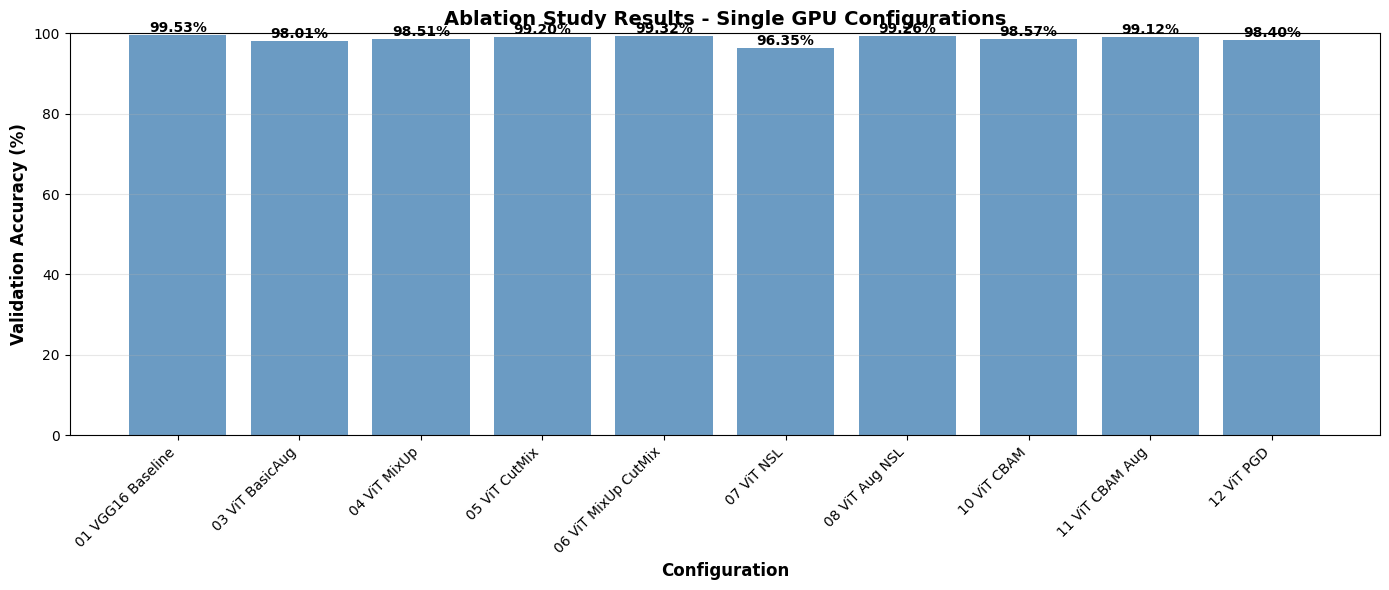

✓ Progression plot saved to: novelty_files/visualizations/ablation_progression.png


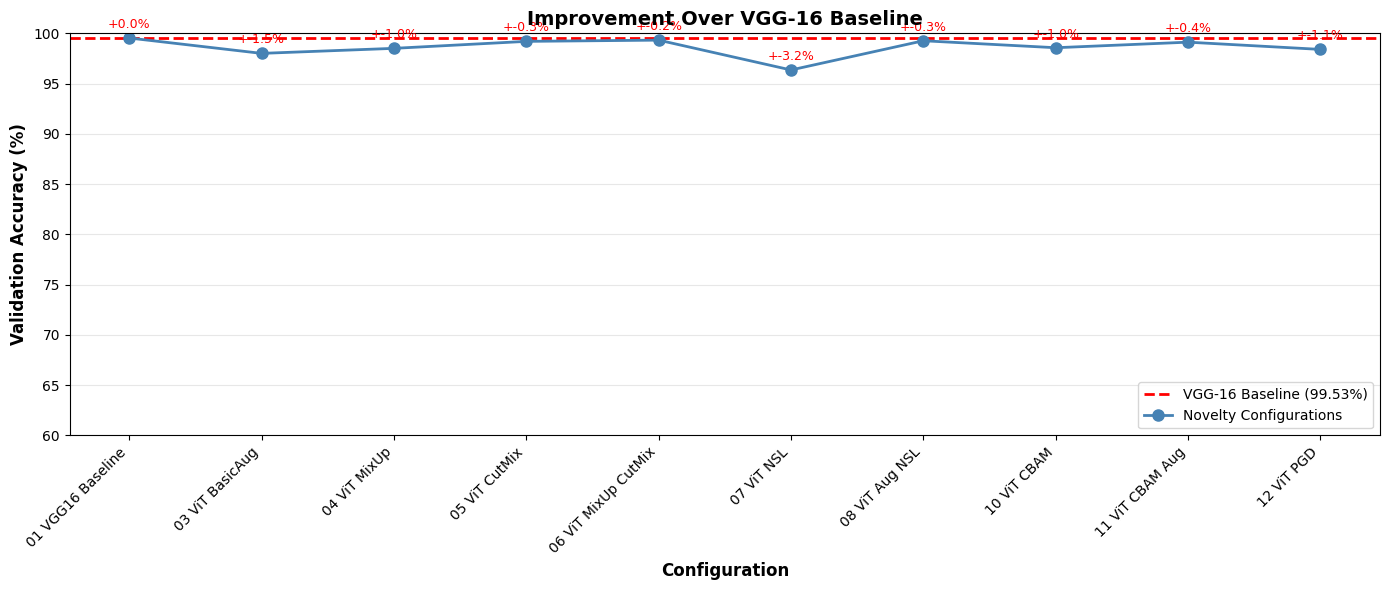

In [23]:
# ============================================================
# CELL 23: VISUALIZE RESULTS
# ============================================================

print("\n" + "="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

# Extract data for plotting
config_names = []
accuracies = []

for name, data in results.items():
    if data is not None:
        config_names.append(name.replace('_', ' '))
        accuracies.append(data['val_accuracy'])

if len(accuracies) > 0:
    # Create bar chart
    fig, ax = plt.subplots(figsize=(14, 6))
    
    bars = ax.bar(range(len(config_names)), accuracies, color='steelblue', alpha=0.8)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Configuration', fontsize=12, fontweight='bold')
    ax.set_ylabel('Validation Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title('Ablation Study Results - Single GPU Configurations', 
                 fontsize=14, fontweight='bold')
    ax.set_xticks(range(len(config_names)))
    ax.set_xticklabels(config_names, rotation=45, ha='right')
    ax.set_ylim(0, 100)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    # Save figure
    vis_path = BASE_DIR / 'visualizations' / 'ablation_single_gpu_results.png'
    plt.savefig(vis_path, dpi=150, bbox_inches='tight')
    print(f"✓ Bar chart saved to: {vis_path}")
    
    plt.show()
    
    # Create progression plot (if we have baseline)
    if '01_VGG16_Baseline' in results and results['01_VGG16_Baseline'] is not None:
        baseline_acc = results['01_VGG16_Baseline']['val_accuracy']
        
        fig, ax = plt.subplots(figsize=(14, 6))
        
        # Plot baseline line
        ax.axhline(y=baseline_acc, color='red', linestyle='--', 
                   linewidth=2, label=f'VGG-16 Baseline ({baseline_acc:.2f}%)')
        
        # Plot progression
        ax.plot(range(len(accuracies)), accuracies, marker='o', 
                markersize=8, linewidth=2, color='steelblue', 
                label='Novelty Configurations')
        
        # Add value labels
        for i, (name, acc) in enumerate(zip(config_names, accuracies)):
            improvement = acc - baseline_acc
            ax.text(i, acc + 1, f'+{improvement:.1f}%', 
                    ha='center', fontsize=9, color='green' if improvement > 0 else 'red')
        
        ax.set_xlabel('Configuration', fontsize=12, fontweight='bold')
        ax.set_ylabel('Validation Accuracy (%)', fontsize=12, fontweight='bold')
        ax.set_title('Improvement Over VGG-16 Baseline', 
                     fontsize=14, fontweight='bold')
        ax.set_xticks(range(len(config_names)))
        ax.set_xticklabels(config_names, rotation=45, ha='right')
        ax.legend(loc='lower right', fontsize=10)
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim(60, 100)
        
        plt.tight_layout()
        
        # Save figure
        prog_path = BASE_DIR / 'visualizations' / 'ablation_progression.png'
        plt.savefig(prog_path, dpi=150, bbox_inches='tight')
        print(f"✓ Progression plot saved to: {prog_path}")
        
        plt.show()

print("="*80)

## CELL 24: Notebook 9A Completion Summary


In [24]:
# ============================================================
# CELL 24: COMPLETION SUMMARY
# ============================================================

print("\n" + "="*80)
print("NOTEBOOK 9A: ABLATION STUDY - COMPLETION SUMMARY")
print("="*80)

# Count completed configurations
num_configs = len([r for r in results.values() if r is not None])
total_configs = len(results)

print(f"\nConfigurations Trained: {num_configs}/{total_configs}")

if num_configs > 0:
    print(f"\nKey Findings:")
    
    # Best configuration
    best_config = max([(name, data) for name, data in results.items() if data is not None],
                     key=lambda x: x[1]['val_accuracy'])
    print(f"  • Best Configuration: {best_config[0]}")
    print(f"    Accuracy: {best_config[1]['val_accuracy']:.2f}%")
    
    # Baseline comparison
    if '01_VGG16_Baseline' in results and results['01_VGG16_Baseline'] is not None:
        baseline = results['01_VGG16_Baseline']['val_accuracy']
        best_acc = best_config[1]['val_accuracy']
        improvement = best_acc - baseline
        print(f"  • VGG-16 Baseline: {baseline:.2f}%")
        print(f"  • Improvement: +{improvement:.2f}% ({(improvement/baseline)*100:.1f}% relative)")

print(f"\n✓ All checkpoints saved to: {CHECKPOINTS_DIR}")
print(f"✓ Results JSON: {METRICS_DIR / 'ablation_single_gpu_results.json'}")
print(f"✓ Summary CSV: {METRICS_DIR / 'ablation_single_gpu_summary.csv'}")
print(f"✓ Visualizations: {BASE_DIR / 'visualizations'}")

print("\n" + "-"*80)
print("NEXT STEPS")
print("-"*80)
print("✓ Notebook 9A COMPLETE: Single GPU Ablations")
print("\nReady to proceed to:")
print("  → Notebook 9B: DDP Export")
print("     • Generate DDP training scripts for Configs 09, 14, 15")
print("     • Execute on 8× H200 GPUs via torchrun")
print("     • Expected runtime: ~6-8 hours per config")

print("\n" + "="*80)

# Save completion status
completion_status = {
    'notebook': 'Notebook 9A: Ablation Study - Single GPU',
    'completed': True,
    'timestamp': pd.Timestamp.now().isoformat(),
    'configs_trained': num_configs,
    'total_configs': total_configs,
    'best_config': best_config[0] if num_configs > 0 else None,
    'best_accuracy': float(best_config[1]['val_accuracy']) if num_configs > 0 else None,
}

completion_path = BASE_DIR / 'logs' / 'notebook_09a_completion.json'
with open(completion_path, 'w') as f:
    json.dump(completion_status, f, indent=2)

print(f"✓ Completion status saved to: {completion_path}")
print("="*80)


NOTEBOOK 9A: ABLATION STUDY - COMPLETION SUMMARY

Configurations Trained: 10/10

Key Findings:
  • Best Configuration: 01_VGG16_Baseline
    Accuracy: 99.53%
  • VGG-16 Baseline: 99.53%
  • Improvement: +0.00% (0.0% relative)

✓ All checkpoints saved to: novelty_files/checkpoints/ablation
✓ Results JSON: novelty_files/metrics/ablation_single_gpu_results.json
✓ Summary CSV: novelty_files/metrics/ablation_single_gpu_summary.csv
✓ Visualizations: novelty_files/visualizations

--------------------------------------------------------------------------------
NEXT STEPS
--------------------------------------------------------------------------------
✓ Notebook 9A COMPLETE: Single GPU Ablations

Ready to proceed to:
  → Notebook 9B: DDP Export
     • Generate DDP training scripts for Configs 09, 14, 15
     • Execute on 8× H200 GPUs via torchrun
     • Expected runtime: ~6-8 hours per config

✓ Completion status saved to: novelty_files/logs/notebook_09a_completion.json
